In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/orginal data.csv")

# Basic info
print("Shape:", df.shape)
df.head()


Shape: (53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


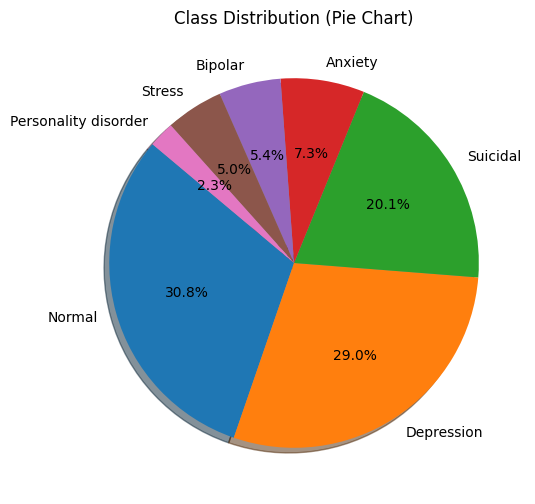

In [3]:
import matplotlib.pyplot as plt

# Class distribution as pie chart
plt.figure(figsize=(6, 6))
df['status'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=140,
    shadow=True
)
plt.ylabel("")  # remove y-axis label
plt.title("Class Distribution (Pie Chart)")
plt.show()


**AFTER DATA AUGMENTATION**

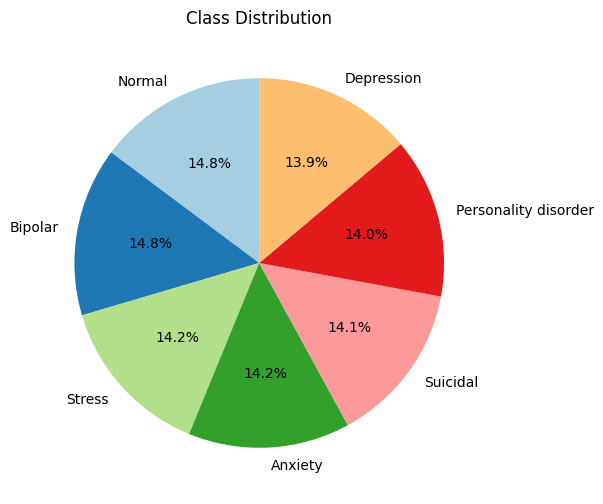

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset from a given path
csv_path = "/content/balanced_dataset_clean_dataset_cleaned_x.csv"
df = pd.read_csv(csv_path)


if 'status' not in df.columns:
    raise ValueError("The CSV file must contain a 'status' column.")


class_counts = df['status'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title('Class Distribution')
plt.show()


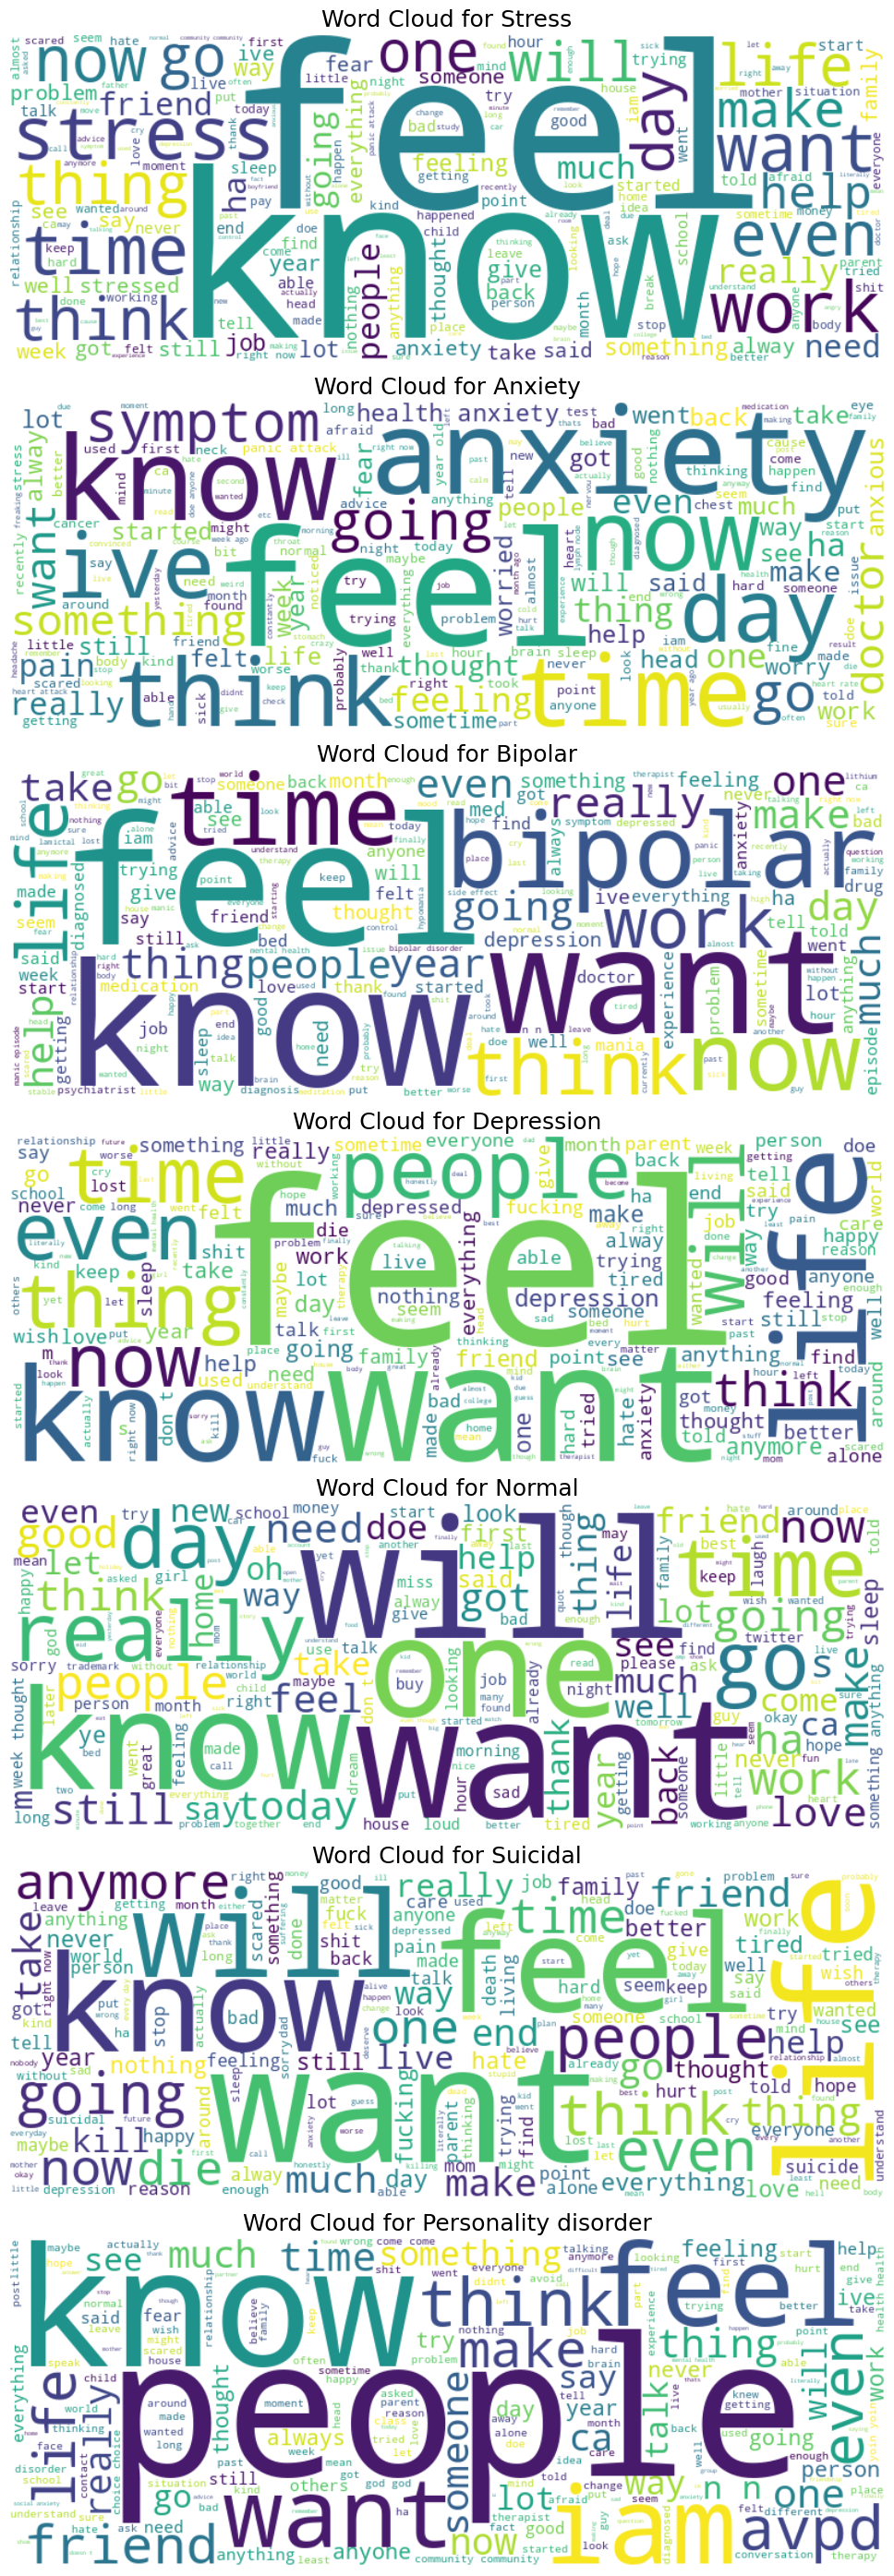

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4 * len(df['status'].unique())))

for i, cls in enumerate(df['status'].unique()):
    # Create one big text string for this class
    text = " ".join(df[df['status'] == cls]['statement'].astype(str))

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800,
        height=300,
        background_color='white'
    ).generate(text)

    # Plot
    plt.subplot(len(df['status'].unique()), 1, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {cls}", fontsize=18)

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, create_optimizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle
#----------------------------------------
# Load dataset
#----------------------------------------
df = pd.read_csv("/content/balanced_dataset_clean_dataset_cleaned_x.csv")
texts = df['statement'].astype(str).tolist()
labels = df['status'].tolist()

#----------------------------------------
# Encode labels
#----------------------------------------
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
labels_onehot = to_categorical(labels_encoded, num_classes=num_classes)

#----------------------------------------
# Split data
#----------------------------------------
X_train, X_val, y_train, y_val = train_test_split(texts, labels_onehot, test_size=0.2, random_state=42)

#----------------------------------------
# Tokenizer
#----------------------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")



train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

#----------------------------------------
# Convert tokenizer outputs to TF tensors
#----------------------------------------
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.constant(val) for key, val in train_encodings.items()},
    tf.constant(y_train, dtype=tf.float32)
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.constant(val) for key, val in val_encodings.items()},
    tf.constant(y_val, dtype=tf.float32)
)).batch(16)


#----------------------------------------
# Model
#----------------------------------------
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_classes,
    from_pt=True
)
#----------------------------------------
# Optimizer
#----------------------------------------
steps_per_epoch = len(train_dataset)
num_train_steps = steps_per_epoch * 3
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, lr_schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

#----------------------------------------
# Compile
#----------------------------------------
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#----------------------------------------
# Train
#----------------------------------------
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

#----------------------------------------
# Save model & tokenizer
#----------------------------------------
model.save_pretrained("distilbert-mental-health-model")
tokenizer.save_pretrained("distilbert-mental-health-model")
#----------------------------------------
# Save label encoder
#----------------------------------------
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


def predict(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)
    logits = model(inputs).logits
    probs = tf.nn.softmax(logits, axis=1)
    pred = tf.argmax(probs, axis=1).numpy()[0]
    return label_encoder.classes_[pred], float(tf.reduce_max(probs).numpy())

# Try prediction
print(predict("I feel hopeless and empty every day."))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing

Epoch 1/3
5533/5533 [==============================] - 1299s 232ms/step - loss: 0.6868 - accuracy: 0.7565 - val_loss: 0.3755 - val_accuracy: 0.8590
Epoch 2/3
5533/5533 [==============================] - 1280s 231ms/step - loss: 0.2638 - accuracy: 0.9006 - val_loss: 0.2842 - val_accuracy: 0.8930
Epoch 3/3
5533/5533 [==============================] - 1279s 231ms/step - loss: 0.1393 - accuracy: 0.9466 - val_loss: 0.2614 - val_accuracy: 0.9082


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


(np.str_('Depression'), 0.640222430229187)


615/615 [==============================] - 43s 71ms/step

Test Accuracy: 0.9082

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.96      0.97      0.96      1361
             Bipolar       0.97      0.98      0.97      1402
          Depression       0.75      0.72      0.74      1338
              Normal       0.95      0.94      0.94      1471
Personality disorder       0.98      0.99      0.98      1349
              Stress       0.95      0.96      0.96      1426
            Suicidal       0.79      0.80      0.80      1489

            accuracy                           0.91      9836
           macro avg       0.91      0.91      0.91      9836
        weighted avg       0.91      0.91      0.91      9836



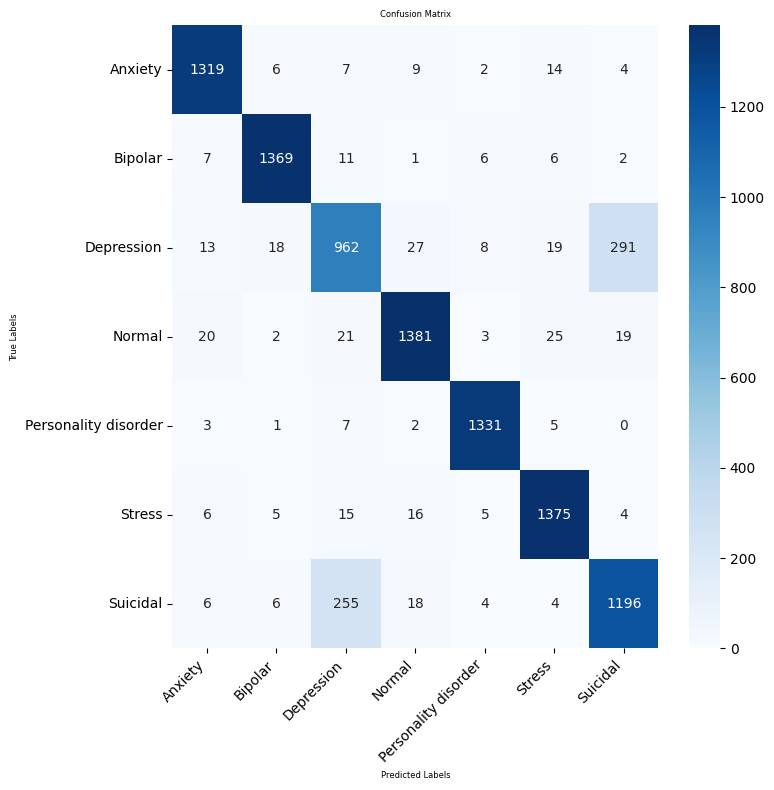

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred_probs = model.predict(val_dataset)
y_pred = np.argmax(y_pred_probs.logits, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(8, 8))
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix", fontsize=6)
plt.xlabel("Predicted Labels", fontsize=6)
plt.ylabel("True Labels", fontsize=6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

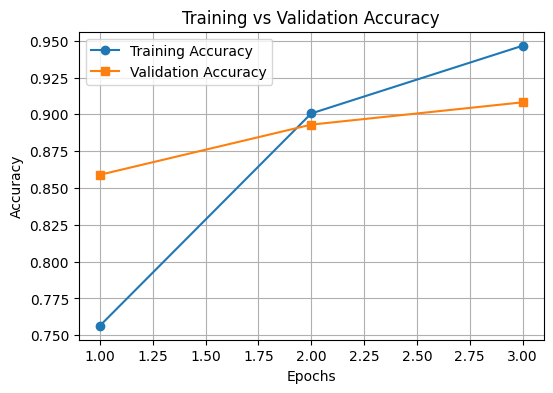

In [10]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(6,4))
plt.plot(epochs, acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import pandas as pd


bert_model = model.distilbert


N = 300
sample_texts = texts[:N]
sample_labels = labels_onehot[:N]

encodings = tokenizer(
    sample_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="tf"
)

input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']


outputs = bert_model(input_ids, attention_mask=attention_mask, training=False)
embeddings = outputs.last_hidden_state[:, 0, :]


embeddings_np = embeddings.numpy()


sample_labels = np.array(sample_labels)


if sample_labels.ndim > 1 and sample_labels.shape[1] > 1:
    sample_labels = np.argmax(sample_labels, axis=1)


sample_labels = label_encoder.inverse_transform(sample_labels)


tsne = TSNE(n_components=3, random_state=42, perplexity=30)
embeddings_3d = tsne.fit_transform(embeddings_np)


df_3d = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'])
df_3d['status'] = sample_labels


fig = px.scatter_3d(
    df_3d, x='x', y='y', z='z',
    color='status',
    title="3D Visualization of Mental Health Text Embeddings",
    symbol='status'
)
fig.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import pickle

# Function to normalize apostrophes and expand contractions
def expand_contractions(text):
    # Normalize curly apostrophes to straight apostrophes
    text = text.replace("’", "'").replace("‘", "'")

    # Lowercase for matching
    text = text.lower()

    CONTRACTION_MAP = {
        "i'm": "I am",
        "i've": "I have",
        "i'd": "I would",
        "i'll": "I will",
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'ve": " have",
        "'d": " would",
        "'ll": " will"
    }

    for contraction, expansion in CONTRACTION_MAP.items():
        text = re.sub(r"\b{}\b".format(re.escape(contraction)), expansion, text)

    return text


# Load saved model and components
def load_components():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-mental-health-model")
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-mental-health-model")
    with open("label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    return model, tokenizer, label_encoder

# Prediction function
def predict_mental_health(text, model, tokenizer, label_encoder):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)
    logits = model(inputs).logits
    probs = tf.nn.softmax(logits, axis=1)
    pred_class = tf.argmax(probs, axis=1).numpy()[0]
    confidence = float(probs[0][pred_class].numpy())
    predicted_status = label_encoder.classes_[pred_class]
    return predicted_status, confidence

# Main function for user interaction
def main():
    print("Loading mental health prediction model...")
    model, tokenizer, label_encoder = load_components()
    print("Model loaded successfully!")

    print("\nMental Health Status Predictor")
    print("Type 'quit' to exit\n")

    while True:
        user_input = input("How are you feeling today? Describe your mental state: ")

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Goodbye! Take care of yourself.")
            break

        if not user_input.strip():
            print("Please enter some text about how you're feeling.")
            continue

        # Preprocess text (expand contractions)
        processed_input = expand_contractions(user_input)

        # Make prediction
        status, confidence = predict_mental_health(processed_input, model, tokenizer, label_encoder)

        # Display results
        print(f"\nProcessed Input: {processed_input}")
        print(f"Predicted Status: {status}")
        print(f"Confidence: {round(confidence * 100, 1)}%")
        print("\n----------------------------------------\n")

if __name__ == "__main__":
    main()


Loading mental health prediction model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: distilbert-mental-health-model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`